In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
np.random.seed(777)
import math
import keras
import keras.backend as K
import h5py
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Activation, merge, Dense, Flatten, Dropout, concatenate
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, add, GlobalAveragePooling2D
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score
from keras.regularizers import l2
from keras.applications.xception import Xception, preprocess_input
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications import DenseNet201
from keras.applications import DenseNet121

from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Lambda,Concatenate
from keras.layers import SeparableConv2D, AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Add

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

Using TensorFlow backend.


In [3]:
train_dir = 'data/iciar/train/'
test_dir = "data/iciar/test/"

extracted_features_dir = "extracted_features/"
model_name = "Reinhard_Xception_concate"

In [4]:
import keras
import tensorflow as tf
import keras.backend as K

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.2.4
tensorflow Version 1.10.0
dim_ordering: tf


In [5]:
batch_size = 32
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)
epochs = 1000

In [6]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

data/iciar/train/ 0
data/iciar/train/carcinoma 2310
data/iciar/train/non-carcinoma 2310
******************************
data/iciar/test/ 0
data/iciar/test/carcinoma 50
data/iciar/test/non-carcinoma 50


In [7]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    validation_split= 0.25,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

# test_generator_without_aug = test_datagen.flow_from_directory(
#     test_dir_whithout_aug,
#     target_size=(img_height, img_width),
#     batch_size=batch_size,
#     seed = random_seed,
#     shuffle = False,
#     class_mode='categorical')

Found 3466 images belonging to 2 classes.
Found 1154 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [8]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))

nb_test_samples = len(test_generator.filenames)
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

# nb_test_without_aug_samples = len(test_generator_without_aug.filenames)
# predict_size_test_without_aug = int(math.ceil(nb_test_without_aug_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
# print("nb_test_without_aug_samples:", nb_test_without_aug_samples)
# print("predict_size_test_without_aug_samples:", predict_size_test_without_aug)
print("nb_test_samples:", nb_test_samples)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 3466
nb_validation_samples: 1154

predict_size_train: 109
predict_size_validation: 37
nb_test_samples: 100
predict_size_test: 4

 num_classes: 2


In [9]:
from keras.backend.tensorflow_backend import get_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import set_session

def reset_keras_tf_session():
    """
    this function clears the gpu memory and set the 
    tf session to not use the whole gpu
    """
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    set_session(tf.Session(config=config))


reset_keras_tf_session()

In [10]:
from keras.applications.mobilenetv2 import MobileNetV2
from keras.applications.densenet import DenseNet169
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.applications.nasnet import NASNetMobile

input_tensor = Input(shape = input_shape)  

base_model1=VGG19(input_shape= input_shape,weights='imagenet', include_top=False, input_tensor=input_tensor)
base_model2=MobileNetV2(input_shape= input_shape,weights='imagenet', include_top=False, input_tensor=input_tensor)
base_model3=DenseNet201(input_shape= input_shape,weights='imagenet', include_top=False, input_tensor=input_tensor)

x1 = base_model1.output
x1 = GlobalAveragePooling2D()(x1)

x2 = base_model2.output
x2 = GlobalAveragePooling2D()(x2)

x3 = base_model3.output
x3 = GlobalAveragePooling2D()(x3)

merge = concatenate([x1, x2, x3])
predictions = Dense(num_classes, activation='softmax')(merge)

model = Model(inputs=input_tensor,outputs=predictions)

In [11]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 input_1
1 zero_padding2d_1
2 conv1/conv
3 conv1/bn
4 conv1/relu
5 zero_padding2d_2
6 pool1
7 conv2_block1_0_bn
8 conv2_block1_0_relu
9 conv2_block1_1_conv
10 conv2_block1_1_bn
11 conv2_block1_1_relu
12 conv2_block1_2_conv
13 conv2_block1_concat
14 conv2_block2_0_bn
15 conv2_block2_0_relu
16 conv2_block2_1_conv
17 conv2_block2_1_bn
18 conv2_block2_1_relu
19 conv2_block2_2_conv
20 conv2_block2_concat
21 conv2_block3_0_bn
22 conv2_block3_0_relu
23 conv2_block3_1_conv
24 conv2_block3_1_bn
25 conv2_block3_1_relu
26 conv2_block3_2_conv
27 conv2_block3_concat
28 conv2_block4_0_bn
29 conv2_block4_0_relu
30 conv2_block4_1_conv
31 conv2_block4_1_bn
32 conv2_block4_1_relu
33 conv2_block4_2_conv
34 conv2_block4_concat
35 conv2_block5_0_bn
36 conv2_block5_0_relu
37 conv2_block5_1_conv
38 conv2_block5_1_bn
39 conv2_block5_1_relu
40 conv2_block5_2_conv
41 conv2_block5_concat
42 conv2_block6_0_bn
43 conv2_block6_0_relu
44 conv2_block6_1_conv
45 conv2_block6_1_bn
46 conv2_block6_1_relu
47 conv2_block

In [12]:
c1 = model.layers[7].output 
c1 = GlobalAveragePooling2D()(c1)       

c2 = model.layers[53].output
c2 = GlobalAveragePooling2D()(c2)       

c3 = model.layers[141].output
c3 = GlobalAveragePooling2D()(c3)       

c4 = model.layers[481].output
c4 = GlobalAveragePooling2D()(c4) 

c5 = model.layers[827].output
c5 = GlobalAveragePooling2D()(c5) 

c6 = model.layers[835].output
c6 = GlobalAveragePooling2D()(c6) 

c7 = model.layers[851].output
c7 = GlobalAveragePooling2D()(c7) 

c8 = model.layers[866].output
c8 = GlobalAveragePooling2D()(c8) 

con = concatenate([c1, c2, c3, c4, c5, c6, c7, c8])

bottleneck_final_model = Model(inputs=model.input, outputs=con)

In [13]:
bottleneck_final_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

Total params: 19,488,064
Trainable params: 19,236,096
Non-trainable params: 251,968
__________________________________________________________________________________________________


In [14]:
bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [15]:
bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [16]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [17]:
dropout_rate = 0.5

model = Sequential()
# model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(num_classes, activation=tf.nn.softmax))

adam_opt2=Adam(lr = 0.001, beta_1=0.6, beta_2=0.8, amsgrad=True)

model.compile(optimizer=adam_opt2, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

with open(extracted_features_dir+'history_'+model_name+'.txt','w') as f:
    f.write(str(history.history))

# model.save_weights(top_model_weights_path)
# model.save(top_model_path)

Train on 3466 samples, validate on 1154 samples
Epoch 1/1000
 - 3s - loss: 0.7316 - acc: 0.6148 - val_loss: 0.5696 - val_acc: 0.7704
Epoch 2/1000
 - 1s - loss: 0.5710 - acc: 0.7069 - val_loss: 0.5146 - val_acc: 0.7626
Epoch 3/1000
 - 1s - loss: 0.5297 - acc: 0.7490 - val_loss: 0.4743 - val_acc: 0.7903
Epoch 4/1000
 - 1s - loss: 0.4890 - acc: 0.7692 - val_loss: 0.5275 - val_acc: 0.7270
Epoch 5/1000
 - 1s - loss: 0.4793 - acc: 0.7764 - val_loss: 0.4648 - val_acc: 0.7799
Epoch 6/1000
 - 1s - loss: 0.4499 - acc: 0.7952 - val_loss: 0.5288 - val_acc: 0.7184
Epoch 7/1000
 - 0s - loss: 0.4401 - acc: 0.8041 - val_loss: 0.4535 - val_acc: 0.7868
Epoch 8/1000
 - 1s - loss: 0.4263 - acc: 0.8148 - val_loss: 0.3832 - val_acc: 0.8336
Epoch 9/1000
 - 0s - loss: 0.4213 - acc: 0.8151 - val_loss: 0.4312 - val_acc: 0.7946
Epoch 10/1000
 - 1s - loss: 0.4052 - acc: 0.8237 - val_loss: 0.3598 - val_acc: 0.8423
Epoch 11/1000
 - 0s - loss: 0.3996 - acc: 0.8263 - val_loss: 0.3746 - val_acc: 0.8440
Epoch 12/1000
 

Epoch 96/1000
 - 0s - loss: 0.1595 - acc: 0.9435 - val_loss: 0.1465 - val_acc: 0.9454
Epoch 97/1000
 - 0s - loss: 0.1659 - acc: 0.9345 - val_loss: 0.1287 - val_acc: 0.9558
Epoch 98/1000
 - 0s - loss: 0.1690 - acc: 0.9342 - val_loss: 0.1341 - val_acc: 0.9515
Epoch 99/1000
 - 0s - loss: 0.1598 - acc: 0.9397 - val_loss: 0.1283 - val_acc: 0.9506
Epoch 100/1000
 - 1s - loss: 0.1657 - acc: 0.9331 - val_loss: 0.1661 - val_acc: 0.9402
Epoch 101/1000
 - 0s - loss: 0.1650 - acc: 0.9403 - val_loss: 0.1229 - val_acc: 0.9575
Epoch 102/1000
 - 1s - loss: 0.1667 - acc: 0.9362 - val_loss: 0.1775 - val_acc: 0.9229
Epoch 103/1000
 - 0s - loss: 0.1511 - acc: 0.9460 - val_loss: 0.1771 - val_acc: 0.9185
Epoch 104/1000
 - 1s - loss: 0.1579 - acc: 0.9391 - val_loss: 0.1460 - val_acc: 0.9402
Epoch 105/1000
 - 0s - loss: 0.1622 - acc: 0.9383 - val_loss: 0.2390 - val_acc: 0.8986
Epoch 106/1000
 - 0s - loss: 0.1591 - acc: 0.9435 - val_loss: 0.1414 - val_acc: 0.9437
Epoch 107/1000
 - 1s - loss: 0.1512 - acc: 0.94

Epoch 191/1000
 - 1s - loss: 0.0897 - acc: 0.9680 - val_loss: 0.0732 - val_acc: 0.9792
Epoch 192/1000
 - 0s - loss: 0.0945 - acc: 0.9700 - val_loss: 0.1336 - val_acc: 0.9428
Epoch 193/1000
 - 0s - loss: 0.0873 - acc: 0.9726 - val_loss: 0.0747 - val_acc: 0.9723
Epoch 194/1000
 - 0s - loss: 0.0845 - acc: 0.9680 - val_loss: 0.0997 - val_acc: 0.9601
Epoch 195/1000
 - 0s - loss: 0.0935 - acc: 0.9691 - val_loss: 0.0658 - val_acc: 0.9801
Epoch 196/1000
 - 0s - loss: 0.0829 - acc: 0.9717 - val_loss: 0.0669 - val_acc: 0.9749
Epoch 197/1000
 - 0s - loss: 0.0879 - acc: 0.9694 - val_loss: 0.0669 - val_acc: 0.9731
Epoch 198/1000
 - 1s - loss: 0.0873 - acc: 0.9697 - val_loss: 0.0743 - val_acc: 0.9757
Epoch 199/1000
 - 0s - loss: 0.0881 - acc: 0.9677 - val_loss: 0.0685 - val_acc: 0.9757
Epoch 200/1000
 - 0s - loss: 0.0942 - acc: 0.9671 - val_loss: 0.0742 - val_acc: 0.9705
Epoch 201/1000
 - 0s - loss: 0.0849 - acc: 0.9691 - val_loss: 0.0656 - val_acc: 0.9801
Epoch 202/1000
 - 1s - loss: 0.0858 - acc: 

 - 0s - loss: 0.0522 - acc: 0.9841 - val_loss: 0.0484 - val_acc: 0.9861
Epoch 286/1000
 - 0s - loss: 0.0528 - acc: 0.9815 - val_loss: 0.0457 - val_acc: 0.9853
Epoch 287/1000
 - 0s - loss: 0.0562 - acc: 0.9818 - val_loss: 0.0899 - val_acc: 0.9627
Epoch 288/1000
 - 0s - loss: 0.0603 - acc: 0.9786 - val_loss: 0.0449 - val_acc: 0.9861
Epoch 289/1000
 - 0s - loss: 0.0580 - acc: 0.9798 - val_loss: 0.0516 - val_acc: 0.9766
Epoch 290/1000
 - 0s - loss: 0.0456 - acc: 0.9864 - val_loss: 0.0502 - val_acc: 0.9818
Epoch 291/1000
 - 1s - loss: 0.0496 - acc: 0.9841 - val_loss: 0.0647 - val_acc: 0.9801
Epoch 292/1000
 - 0s - loss: 0.0590 - acc: 0.9815 - val_loss: 0.0505 - val_acc: 0.9844
Epoch 293/1000
 - 0s - loss: 0.0614 - acc: 0.9801 - val_loss: 0.0515 - val_acc: 0.9844
Epoch 294/1000
 - 0s - loss: 0.0517 - acc: 0.9847 - val_loss: 0.0435 - val_acc: 0.9896
Epoch 295/1000
 - 1s - loss: 0.0611 - acc: 0.9801 - val_loss: 0.0430 - val_acc: 0.9870
Epoch 296/1000
 - 0s - loss: 0.0562 - acc: 0.9815 - val_lo

Epoch 380/1000
 - 0s - loss: 0.0406 - acc: 0.9873 - val_loss: 0.0408 - val_acc: 0.9887
Epoch 381/1000
 - 0s - loss: 0.0405 - acc: 0.9870 - val_loss: 0.0805 - val_acc: 0.9619
Epoch 382/1000
 - 0s - loss: 0.0391 - acc: 0.9885 - val_loss: 0.0396 - val_acc: 0.9861
Epoch 383/1000
 - 0s - loss: 0.0404 - acc: 0.9882 - val_loss: 0.0379 - val_acc: 0.9861
Epoch 384/1000
 - 1s - loss: 0.0401 - acc: 0.9876 - val_loss: 0.0364 - val_acc: 0.9879
Epoch 385/1000
 - 0s - loss: 0.0382 - acc: 0.9893 - val_loss: 0.0485 - val_acc: 0.9879
Epoch 386/1000
 - 0s - loss: 0.0381 - acc: 0.9893 - val_loss: 0.0367 - val_acc: 0.9879
Epoch 387/1000
 - 0s - loss: 0.0373 - acc: 0.9873 - val_loss: 0.0456 - val_acc: 0.9861
Epoch 388/1000
 - 0s - loss: 0.0400 - acc: 0.9882 - val_loss: 0.0439 - val_acc: 0.9809
Epoch 389/1000
 - 0s - loss: 0.0368 - acc: 0.9896 - val_loss: 0.0367 - val_acc: 0.9887
Epoch 390/1000
 - 0s - loss: 0.0383 - acc: 0.9879 - val_loss: 0.0365 - val_acc: 0.9896
Epoch 391/1000
 - 0s - loss: 0.0415 - acc: 

 - 0s - loss: 0.0331 - acc: 0.9902 - val_loss: 0.0359 - val_acc: 0.9879
Epoch 475/1000
 - 0s - loss: 0.0295 - acc: 0.9913 - val_loss: 0.0380 - val_acc: 0.9879
Epoch 476/1000
 - 0s - loss: 0.0367 - acc: 0.9879 - val_loss: 0.0386 - val_acc: 0.9844
Epoch 477/1000
 - 0s - loss: 0.0321 - acc: 0.9899 - val_loss: 0.0354 - val_acc: 0.9879
Epoch 478/1000
 - 0s - loss: 0.0321 - acc: 0.9905 - val_loss: 0.0349 - val_acc: 0.9870
Epoch 479/1000
 - 0s - loss: 0.0363 - acc: 0.9882 - val_loss: 0.0465 - val_acc: 0.9835
Epoch 480/1000
 - 1s - loss: 0.0301 - acc: 0.9916 - val_loss: 0.0325 - val_acc: 0.9913
Epoch 481/1000
 - 0s - loss: 0.0252 - acc: 0.9925 - val_loss: 0.0438 - val_acc: 0.9809
Epoch 482/1000
 - 0s - loss: 0.0315 - acc: 0.9913 - val_loss: 0.0322 - val_acc: 0.9905
Epoch 483/1000
 - 0s - loss: 0.0296 - acc: 0.9922 - val_loss: 0.0377 - val_acc: 0.9887
Epoch 484/1000
 - 0s - loss: 0.0331 - acc: 0.9913 - val_loss: 0.0392 - val_acc: 0.9870
Epoch 485/1000
 - 0s - loss: 0.0290 - acc: 0.9913 - val_lo

Epoch 569/1000
 - 0s - loss: 0.0270 - acc: 0.9937 - val_loss: 0.0318 - val_acc: 0.9879
Epoch 570/1000
 - 0s - loss: 0.0219 - acc: 0.9962 - val_loss: 0.0427 - val_acc: 0.9818
Epoch 571/1000
 - 1s - loss: 0.0281 - acc: 0.9919 - val_loss: 0.0313 - val_acc: 0.9887
Epoch 572/1000
 - 0s - loss: 0.0265 - acc: 0.9916 - val_loss: 0.0310 - val_acc: 0.9887
Epoch 573/1000
 - 1s - loss: 0.0303 - acc: 0.9916 - val_loss: 0.0405 - val_acc: 0.9870
Epoch 574/1000
 - 0s - loss: 0.0317 - acc: 0.9890 - val_loss: 0.0345 - val_acc: 0.9870
Epoch 575/1000
 - 0s - loss: 0.0284 - acc: 0.9925 - val_loss: 0.0329 - val_acc: 0.9905
Epoch 576/1000
 - 1s - loss: 0.0261 - acc: 0.9913 - val_loss: 0.0327 - val_acc: 0.9905
Epoch 577/1000
 - 0s - loss: 0.0259 - acc: 0.9934 - val_loss: 0.0307 - val_acc: 0.9905
Epoch 578/1000
 - 0s - loss: 0.0286 - acc: 0.9911 - val_loss: 0.0355 - val_acc: 0.9887
Epoch 579/1000
 - 0s - loss: 0.0247 - acc: 0.9925 - val_loss: 0.0343 - val_acc: 0.9887
Epoch 580/1000
 - 0s - loss: 0.0259 - acc: 

 - 0s - loss: 0.0202 - acc: 0.9951 - val_loss: 0.0263 - val_acc: 0.9913
Epoch 664/1000
 - 0s - loss: 0.0179 - acc: 0.9957 - val_loss: 0.0538 - val_acc: 0.9783
Epoch 665/1000
 - 0s - loss: 0.0334 - acc: 0.9893 - val_loss: 0.0552 - val_acc: 0.9835
Epoch 666/1000
 - 0s - loss: 0.0254 - acc: 0.9922 - val_loss: 0.0348 - val_acc: 0.9861
Epoch 667/1000
 - 0s - loss: 0.0256 - acc: 0.9928 - val_loss: 0.0372 - val_acc: 0.9853
Epoch 668/1000
 - 0s - loss: 0.0250 - acc: 0.9942 - val_loss: 0.0305 - val_acc: 0.9896
Epoch 669/1000
 - 0s - loss: 0.0189 - acc: 0.9954 - val_loss: 0.0315 - val_acc: 0.9896
Epoch 670/1000
 - 0s - loss: 0.0208 - acc: 0.9945 - val_loss: 0.0633 - val_acc: 0.9740
Epoch 671/1000
 - 0s - loss: 0.0335 - acc: 0.9916 - val_loss: 0.0326 - val_acc: 0.9905
Epoch 672/1000
 - 0s - loss: 0.0304 - acc: 0.9916 - val_loss: 0.0702 - val_acc: 0.9766
Epoch 673/1000
 - 0s - loss: 0.0282 - acc: 0.9922 - val_loss: 0.0307 - val_acc: 0.9913
Epoch 674/1000
 - 0s - loss: 0.0232 - acc: 0.9942 - val_lo

Epoch 758/1000
 - 0s - loss: 0.0139 - acc: 0.9980 - val_loss: 0.0344 - val_acc: 0.9896
Epoch 759/1000
 - 0s - loss: 0.0180 - acc: 0.9942 - val_loss: 0.0435 - val_acc: 0.9887
Epoch 760/1000
 - 0s - loss: 0.0166 - acc: 0.9962 - val_loss: 0.0770 - val_acc: 0.9749
Epoch 761/1000
 - 0s - loss: 0.0219 - acc: 0.9937 - val_loss: 0.0267 - val_acc: 0.9931
Epoch 762/1000
 - 0s - loss: 0.0183 - acc: 0.9934 - val_loss: 0.0290 - val_acc: 0.9913
Epoch 763/1000
 - 0s - loss: 0.0167 - acc: 0.9968 - val_loss: 0.0250 - val_acc: 0.9913
Epoch 764/1000
 - 0s - loss: 0.0149 - acc: 0.9971 - val_loss: 0.0291 - val_acc: 0.9913
Epoch 765/1000
 - 1s - loss: 0.0170 - acc: 0.9962 - val_loss: 0.0340 - val_acc: 0.9887
Epoch 766/1000
 - 0s - loss: 0.0152 - acc: 0.9962 - val_loss: 0.0362 - val_acc: 0.9887
Epoch 767/1000
 - 0s - loss: 0.0164 - acc: 0.9957 - val_loss: 0.0290 - val_acc: 0.9913
Epoch 768/1000
 - 0s - loss: 0.0149 - acc: 0.9957 - val_loss: 0.0391 - val_acc: 0.9887
Epoch 769/1000
 - 0s - loss: 0.0176 - acc: 

 - 1s - loss: 0.0145 - acc: 0.9974 - val_loss: 0.0267 - val_acc: 0.9922
Epoch 853/1000
 - 0s - loss: 0.0133 - acc: 0.9962 - val_loss: 0.0273 - val_acc: 0.9905
Epoch 854/1000
 - 0s - loss: 0.0164 - acc: 0.9962 - val_loss: 0.0286 - val_acc: 0.9922
Epoch 855/1000
 - 1s - loss: 0.0146 - acc: 0.9962 - val_loss: 0.0326 - val_acc: 0.9905
Epoch 856/1000
 - 0s - loss: 0.0161 - acc: 0.9962 - val_loss: 0.0435 - val_acc: 0.9870
Epoch 857/1000
 - 1s - loss: 0.0162 - acc: 0.9957 - val_loss: 0.0253 - val_acc: 0.9931
Epoch 858/1000
 - 0s - loss: 0.0133 - acc: 0.9977 - val_loss: 0.0356 - val_acc: 0.9913
Epoch 859/1000
 - 0s - loss: 0.0174 - acc: 0.9945 - val_loss: 0.0284 - val_acc: 0.9913
Epoch 860/1000
 - 1s - loss: 0.0130 - acc: 0.9968 - val_loss: 0.0342 - val_acc: 0.9896
Epoch 861/1000
 - 0s - loss: 0.0156 - acc: 0.9971 - val_loss: 0.0296 - val_acc: 0.9913
Epoch 862/1000
 - 0s - loss: 0.0123 - acc: 0.9977 - val_loss: 0.0312 - val_acc: 0.9905
Epoch 863/1000
 - 0s - loss: 0.0154 - acc: 0.9962 - val_lo

Epoch 947/1000
 - 1s - loss: 0.0146 - acc: 0.9971 - val_loss: 0.0263 - val_acc: 0.9913
Epoch 948/1000
 - 1s - loss: 0.0159 - acc: 0.9957 - val_loss: 0.0265 - val_acc: 0.9922
Epoch 949/1000
 - 1s - loss: 0.0126 - acc: 0.9971 - val_loss: 0.0322 - val_acc: 0.9896
Epoch 950/1000
 - 1s - loss: 0.0117 - acc: 0.9983 - val_loss: 0.0265 - val_acc: 0.9905
Epoch 951/1000
 - 1s - loss: 0.0180 - acc: 0.9942 - val_loss: 0.0345 - val_acc: 0.9879
Epoch 952/1000
 - 1s - loss: 0.0166 - acc: 0.9965 - val_loss: 0.0345 - val_acc: 0.9896
Epoch 953/1000
 - 1s - loss: 0.0116 - acc: 0.9977 - val_loss: 0.0642 - val_acc: 0.9775
Epoch 954/1000
 - 0s - loss: 0.0169 - acc: 0.9945 - val_loss: 0.0229 - val_acc: 0.9931
Epoch 955/1000
 - 0s - loss: 0.0155 - acc: 0.9968 - val_loss: 0.0276 - val_acc: 0.9913
Epoch 956/1000
 - 0s - loss: 0.0222 - acc: 0.9931 - val_loss: 0.0337 - val_acc: 0.9896
Epoch 957/1000
 - 0s - loss: 0.0155 - acc: 0.9965 - val_loss: 0.0387 - val_acc: 0.9896
Epoch 958/1000
 - 1s - loss: 0.0164 - acc: 

In [18]:
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.95


Confusion Matrix
[[48  2]
 [ 3 47]]


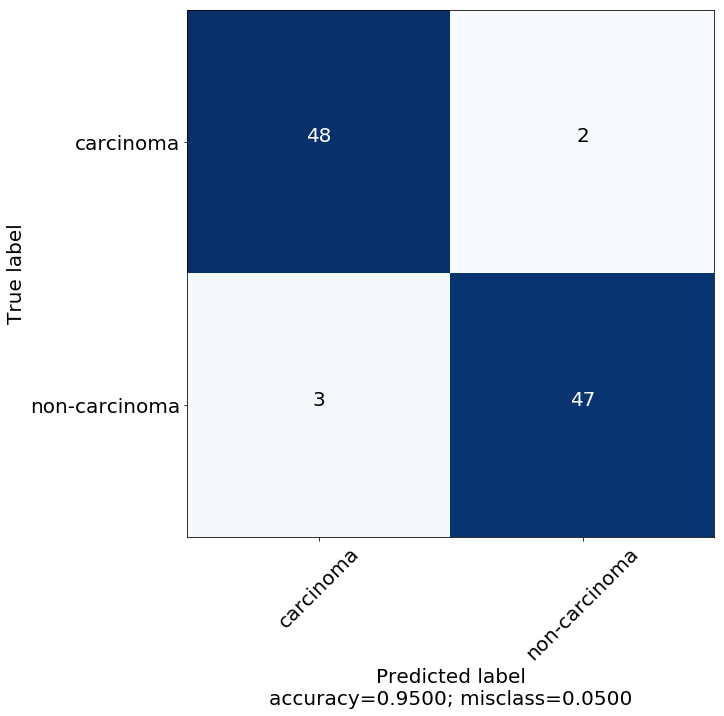

In [19]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [20]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[48  2]
 [ 3 47]]
               precision    recall  f1-score   support

    carcinoma       0.94      0.96      0.95        50
non-carcinoma       0.96      0.94      0.95        50

  avg / total       0.95      0.95      0.95       100



In [21]:
total=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Sensitivity :  94.11764705882352
Specificity :  95.91836734693877


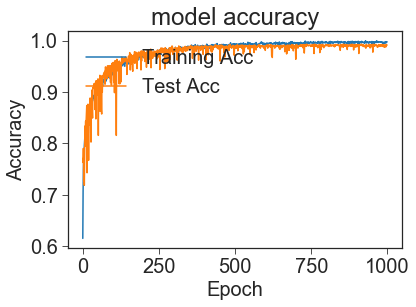

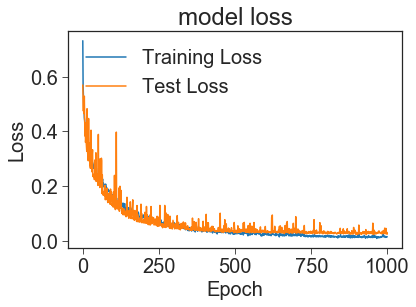

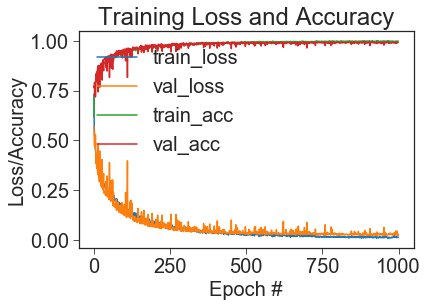

In [22]:
plt.style.use("seaborn-ticks")

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")